In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import pylab as pl
import geopandas as gpd
import matplotlib as mpl
import os
import shapely
import collections
from fiona.crs import from_epsg
import smoomapy
import jenkspy


from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path

import choroplathNYC as cp

%pylab inline
pl.rcParams['font.size'] = 20


Populating the interactive namespace from numpy and matplotlib


# NYC zipcodes and census tracts geometry

In [2]:
zips = gpd.GeoDataFrame.from_file("data/ZIP_CODE_040114.shp")
zips = zips.to_crs(epsg=4326)
NYgeodata = gpd.GeoDataFrame.from_file("data/cb_2014_36_tract_500k/cb_2014_36_tract_500k.shp")


# language data from American Community Survey 2015 and 2010
 we assume the relevant languages are 
 "Hindi", "Urdu", "Arabic", and "Other_Indic_languages"

## pre processed data by Jill Hubley 2015

In [3]:
languageBd = pd.read_csv("data/languages_all1.csv")
languageBd['tot']  = languageBd.iloc[:,1:].sum(axis=1)
#languageBd['tot'] = languageBd[:,2:]
languageBd['allrelev'] = languageBd[["Hindi", "Urdu", "Arabic"]].astype(float).sum(axis=1)
languageBd.drop(languageBd.columns[5:-2], axis=1, inplace=True)

In [4]:
languageBd.head()


id  Arabic  Hindi  Urdu  Other_Indic_languages   tot  \
0  1400000US36047000100      14      0     0                     51  4118   
1  1400000US36047000200      42      0     0                      0  1382   
2  1400000US36047000301       0      0     0                      0  3719   
3  1400000US36047000501      19     11    11                      0  4331   
4  1400000US36047000502       0     43     0                      0  2438   

   allrelev  
0      14.0  
1      42.0  
2       0.0  
3      41.0  
4      43.0

## AMESA population by numbers 2015

In [5]:
geoLanguage = NYgeodata.merge(languageBd, how="inner", right_on="id", left_on=u'AFFGEOID')#.plot(figsize = (20,20), column='allrelev')


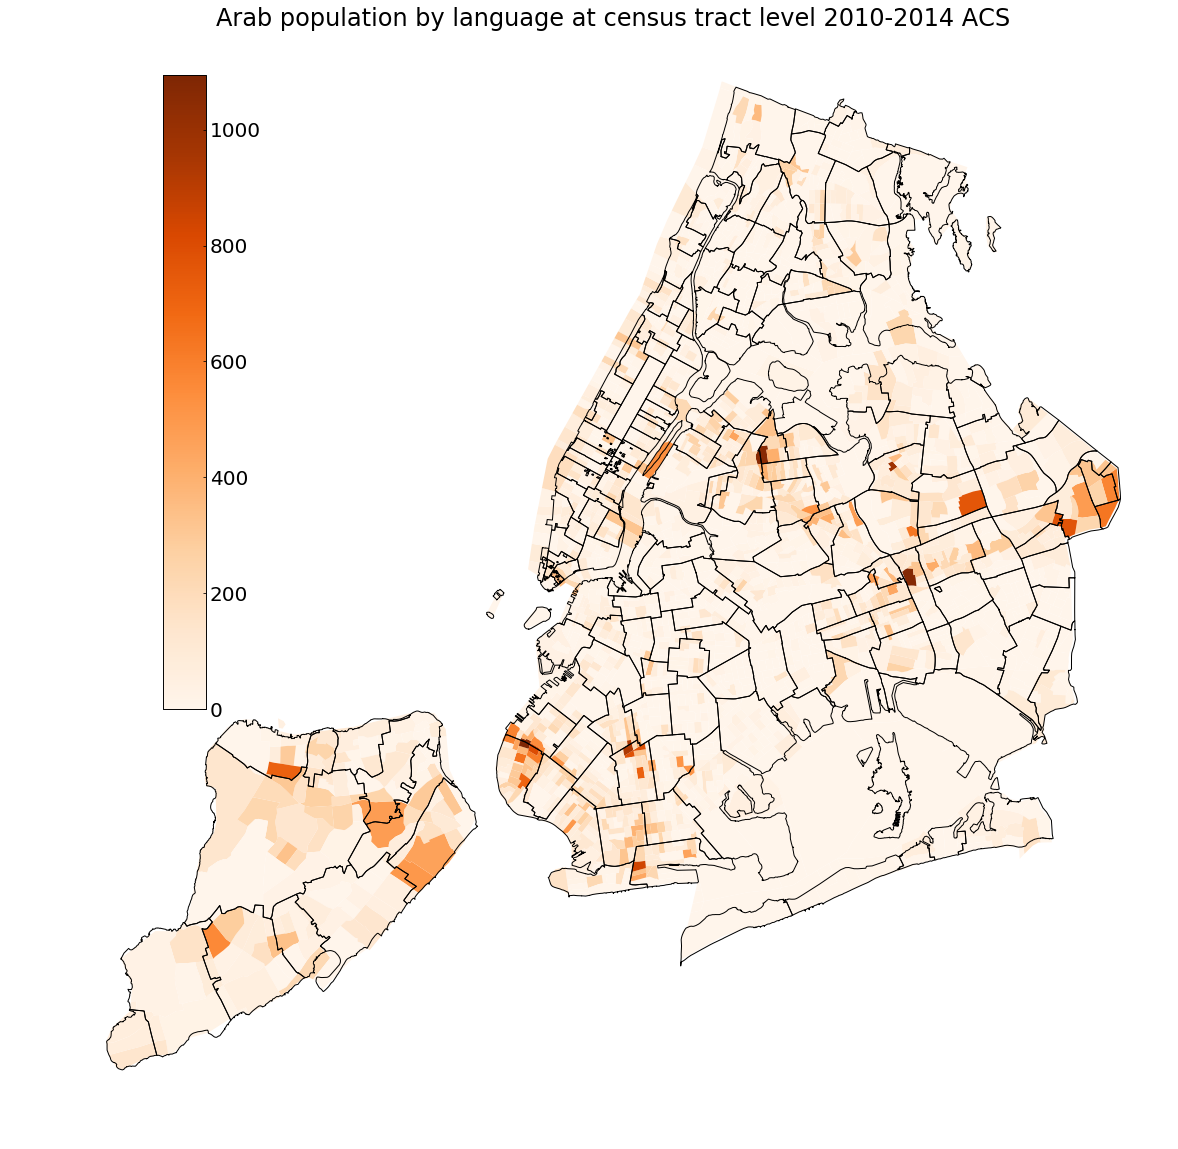

In [6]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)

#.drop(["id"], inplace=True)

f, ax = cp.choroplethNYC(geoLanguage, "allrelev", kind='continuous', cmap="Oranges", ax=ax, lw=0)
title = ax.set_title("Arab population by language at census tract level 2010-2014 ACS")
zips.plot(ax=ax, column=None, facecolor='none')
pl.savefig("ArabCountByLanguage15.png")

## AMESA population fraction 2015

In [7]:
# caluclating fractions
geoLanguage['fraction'] = geoLanguage[['allrelev']].astype(float).values / geoLanguage[['tot']].astype(float).values
geoLanguage['fractionArabic'] = geoLanguage[['Arabic']].astype(float).values / geoLanguage[['tot']].astype(float).values
geoLanguage['fractionHindi'] = geoLanguage[['Hindi']].astype(float).values / geoLanguage[['tot']].astype(float).values
geoLanguage['fractionUrdu'] = geoLanguage[['Urdu']].astype(float).values / geoLanguage[['tot']].astype(float).values
geoLanguage['fractionOther'] = geoLanguage[['Other_Indic_languages']].astype(float).values / geoLanguage[['tot']].astype(float).values

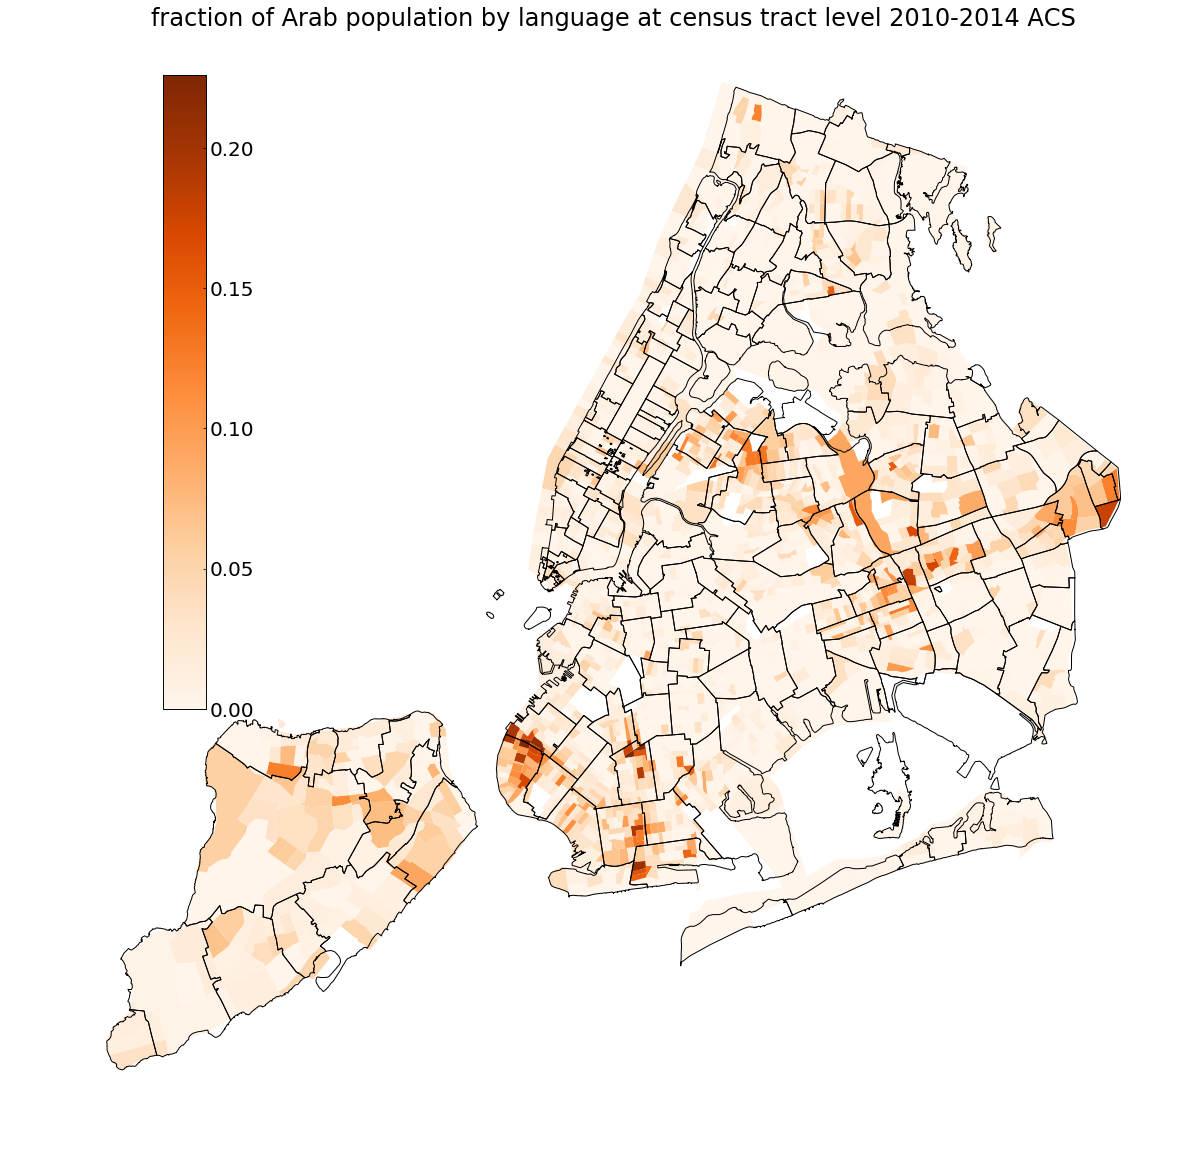

In [8]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)

#.drop(["id"], inplace=True)

f, ax = cp.choroplethNYC(geoLanguage, "fraction", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("fraction of Arab population by language at census tract level 2010-2014 ACS")
zips.plot(ax=ax, column=None, facecolor='none')

pl.savefig("ArabByLanguage15.png")

## AMESA spatial density 2015

In [9]:
geoLanguage['ctareaf2'] = geoLanguage[['geometry']].to_crs(epsg=2263)["geometry"].area / (2.788*10**7)
geoLanguage['density'] = geoLanguage[['allrelev']].astype(float).values.flatten() / geoLanguage['ctareaf2']
                    
## people per sq mile

number of zipcodes with area > 0.1 square miles 37
number of zipcodes with density over 20000 ppl/square mi 2


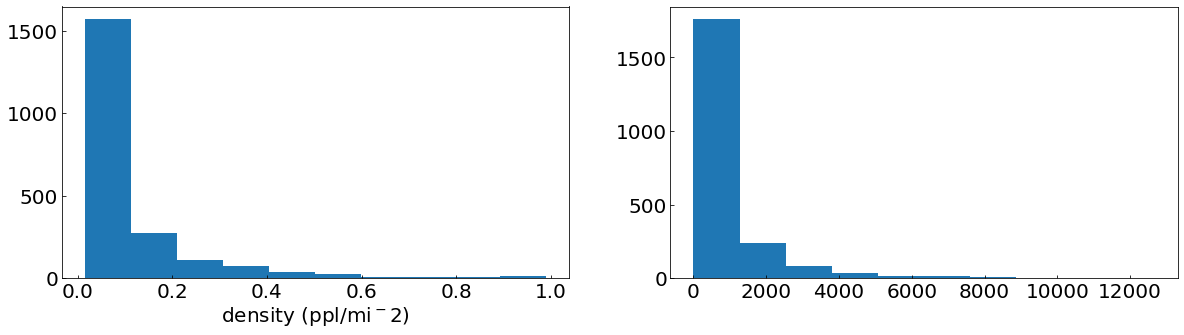

In [10]:
# tmp = [geoLanguage[['geometry']].to_crs(epsg=2263)["geometry"].area / (2.788*10**7)<1 ]
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)

pl.hist(geoLanguage['ctareaf2'].values[geoLanguage['ctareaf2'].values<1])
ax1.set_xlabel(r"area (mi$^2$)")
geoLanguage[geoLanguage['ctareaf2'].values<0.00001]['density']
geoLanguage.iloc[geoLanguage['density'].values.argmax()]

ax2 = fig.add_subplot(122)
pl.hist(geoLanguage['density'].values[geoLanguage['density'].values<15000])
ax1.set_xlabel(r"density (ppl/mi$^-2$)")

print ("number of zipcodes with area > 0.1 square miles", sum(geoLanguage['ctareaf2'].values>1))
print ("number of zipcodes with density over 20000 ppl/square mi", sum(geoLanguage['density'].values>15000))

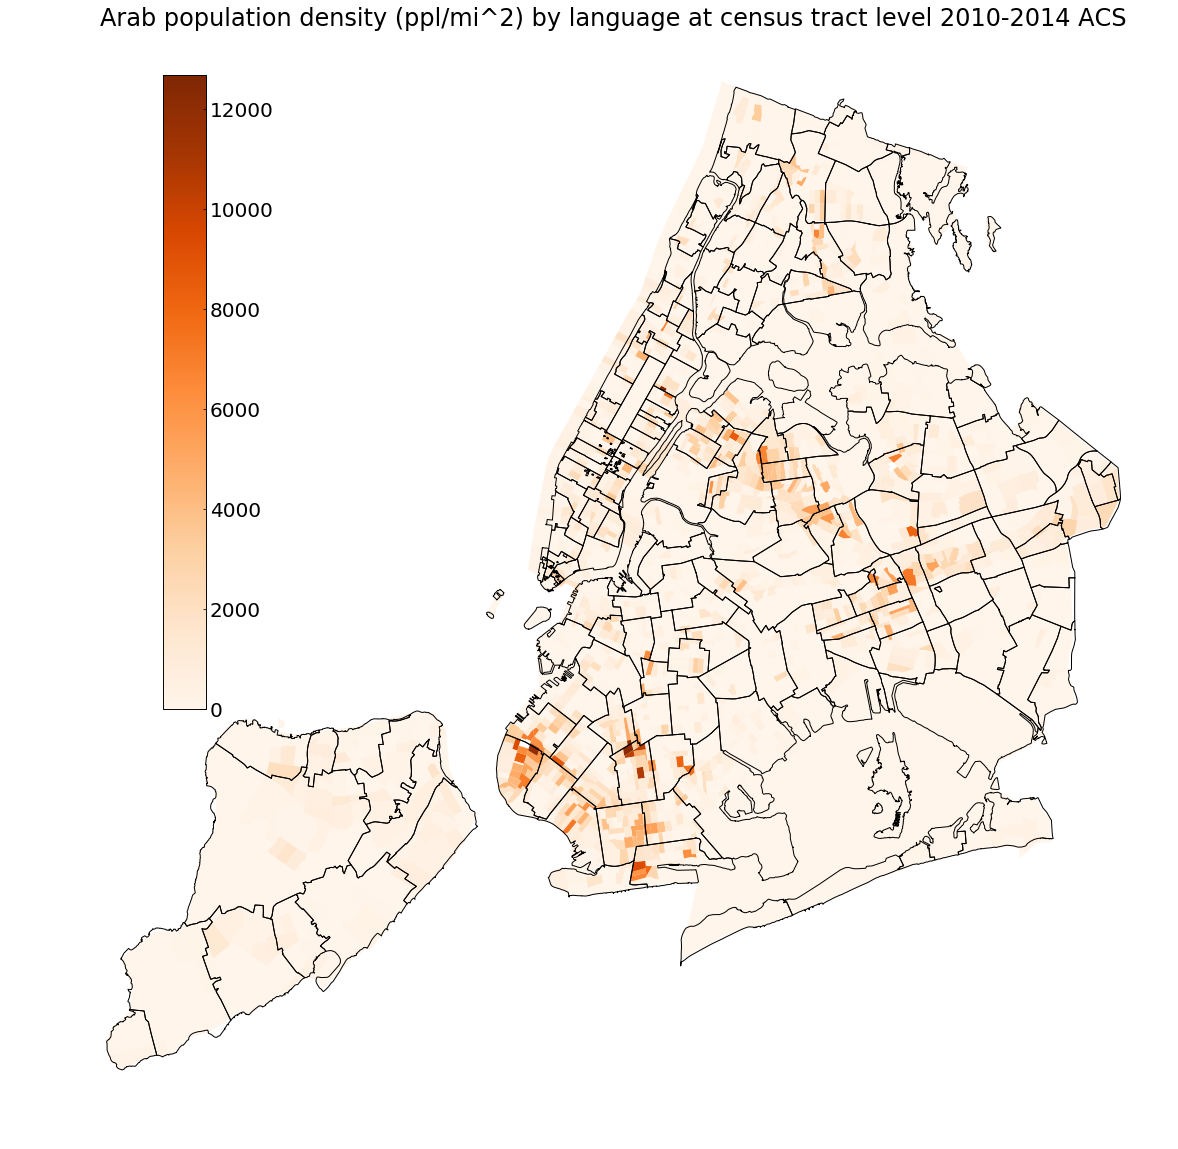

In [11]:
# note: in the density plot the 2 highest density zipcode are removed as including it stretched the scale so that details are lost
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)

#.drop(["id"], inplace=True)

f, ax = cp.choroplethNYC(geoLanguage[geoLanguage['density'].values<15000], "density", 
                         kind='continuous', cmap="Oranges", ax=ax, lw=0)
title = ax.set_title("Arab population density (ppl/mi^2) by language at census tract level 2010-2014 ACS")
zips.plot(ax=ax, column=None, facecolor='none')
pl.savefig("ArabDensity15.png")

## Spatial smoothing over density:
the smoothing kernel is exponenial with exponent = 2 and distance where the 500 feet is chosen as distance for  of probability of the spatial interaction function is 0.5

Index([u'max', u'geometry', u'min', u'center'], dtype='object')

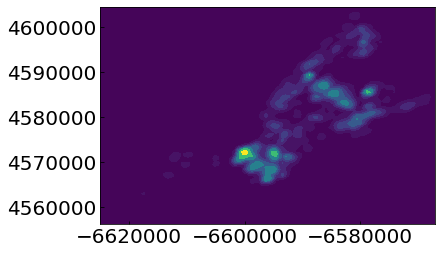

In [12]:
StePot = smoomapy.SmoothStewart(geoLanguage.to_crs(epsg=2263), "density", span=500,
                           beta=2, mask=geoLanguage.to_crs(epsg=2263))
res = StePot.render(nb_class=8, func_grid="matplotlib",
                        disc_func="jenks", output="GeoDataFrame")
res.columns

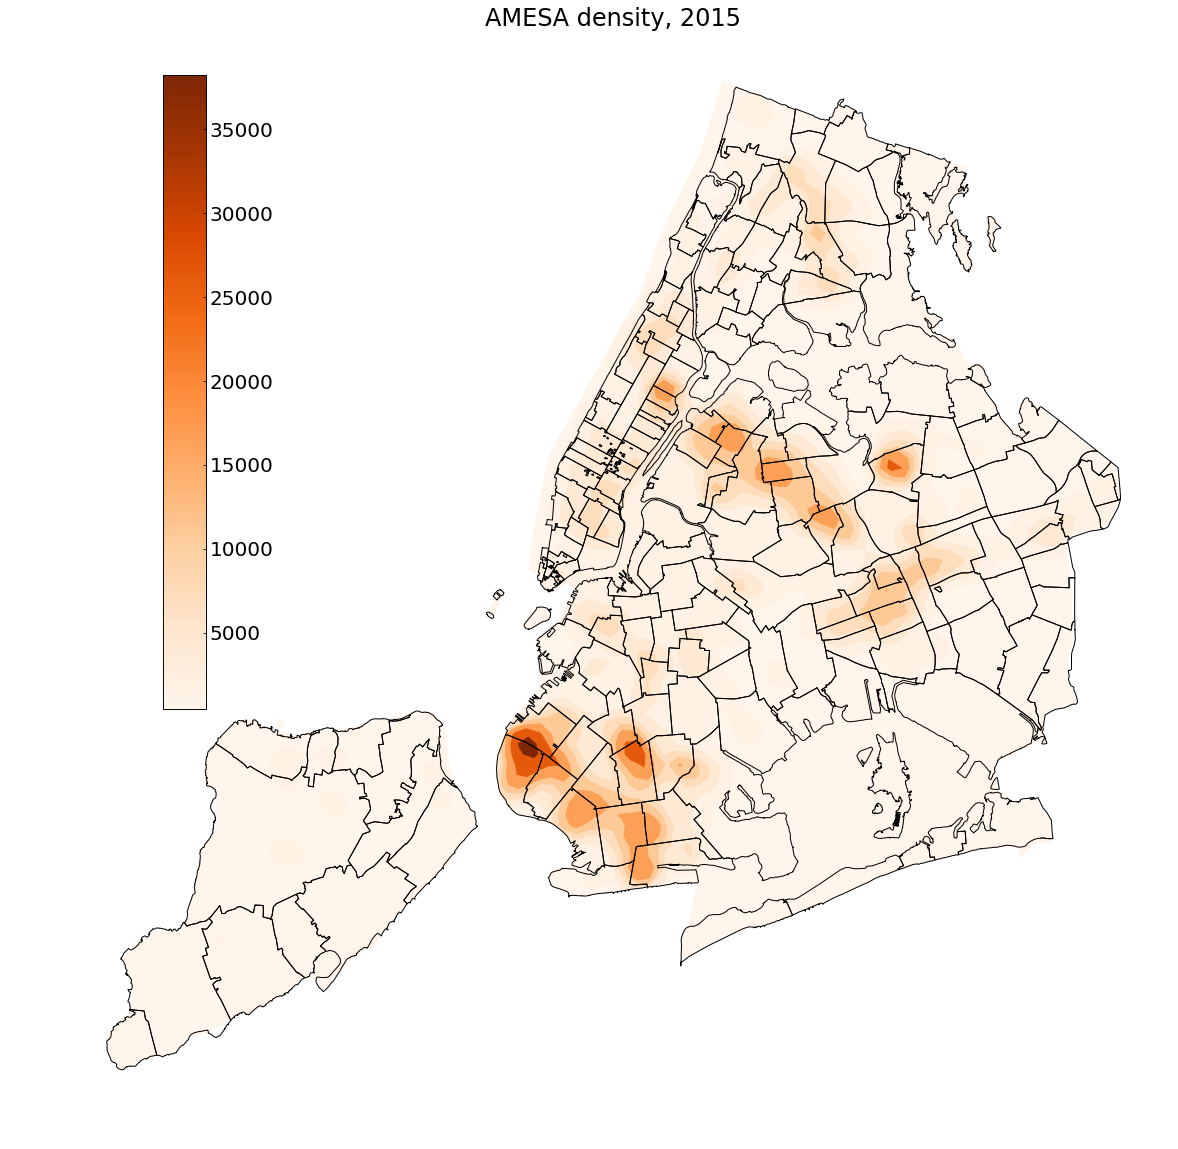

In [13]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)
f, ax = cp.choroplethNYC(res.to_crs(epsg=4326), "center", kind='continuous', cmap="Oranges", ax=ax, lw=0)

zips.plot(ax=ax, column=None, facecolor='none')
title = ax.set_title("AMESA density, 2015")

pl.savefig("ArabDensity2015Smooth.png")

## Aggregating at zipcode level

the cells below calculate the relevant quantities: densities and counts of AMESA people at the zipcode level

this is done in a loop and the performance is bad. Be patient

In [ ]:
denszips = pd.DataFrame(zips[['ZIPCODE','AREA']])
denszips['avdens'] = np.zeros(len(zips['ZIPCODE'].values)) * np.nan
denszips['counts'] = np.zeros(len(zips['ZIPCODE'].values)) * np.nan
N = len(zips)

for i in range(N):
    print ("zipcode: {0:s} ({1:d}/{2:d})".format(zips[i:i+1]["ZIPCODE"].values[0], 
                                                 i + 1, N))
    
    tmp = gpd.overlay(zips.iloc[i:i+1], res, how='intersection')
    tmp.crs = from_epsg(4326) 
    densities = tmp["center"].values 
    areas = tmp.to_crs(epsg=2263)["geometry"].area/(2.788*10**7)
    denszips.set_value(i, 'avdens', np.average(densities, weights=areas))
    
    '''
    ax = figure(figsize=(20,20)).add_subplot(111)
    res.plot(ax=ax, column=None, facecolor='none')
    zips.plot(ax=ax, column=None, facecolor='none')
    zips.iloc[:2].plot(ax=ax, column=None, facecolor='none')
    tmp.plot(ax=ax)
    '''
print ("")

zipcode: 11436 (1/263)
zipcode: 11213 (2/263)
zipcode: 11212 (3/263)
zipcode: 11225 (4/263)
zipcode: 11218 (5/263)
zipcode: 11226 (6/263)
zipcode: 11219 (7/263)
zipcode: 11210 (8/263)
zipcode: 11230 (9/263)
zipcode: 11204 (10/263)
zipcode: 10471 (11/263)
zipcode: 10470 (12/263)
zipcode: 10466 (13/263)
zipcode: 10467 (14/263)
zipcode: 10463 (15/263)
zipcode: 10475 (16/263)
zipcode: 10464 (17/263)
zipcode: 10469 (18/263)
zipcode: 10468 (19/263)
zipcode: 10463 (20/263)
zipcode: 10458 (21/263)
zipcode: 10034 (22/263)
zipcode: 10033 (23/263)
zipcode: 10462 (24/263)
zipcode: 10040 (25/263)
zipcode: 10453 (26/263)
zipcode: 10465 (27/263)
zipcode: 10464 (28/263)
zipcode: 10464 (29/263)
zipcode: 10461 (30/263)
zipcode: 10457 (31/263)
zipcode: 10460 (32/263)
zipcode: 10032 (33/263)
zipcode: 10452 (34/263)
zipcode: 10456 (35/263)
zipcode: 10472 (36/263)
zipcode: 10031 (37/263)
zipcode: 10039 (38/263)
zipcode: 10459 (39/263)
zipcode: 10451 (40/263)
zipcode: 10473 (41/263)
zipcode: 10030 (42/263)
z

In [ ]:
for i in range(N):
    cfips = zips.iloc[i:i+1]["CTY_FIPS"].values[0]
    geotmp = geoLanguage[(geoLanguage[["COUNTYFP"]]== cfips).values.flatten()]
    #print (geotmp.head())
    print ("zipcode: {0:s} ({1:d}/{2:d}, {3:d} cts)".format(zips[i:i+1]["ZIPCODE"].values[0], i + 1, N, 
                                                            len(geotmp)))
    
    tmp = gpd.overlay(zips.iloc[i:i+1], geotmp.to_crs(epsg=4326), how='intersection')
    tmp.crs = from_epsg(4326) 
    counts = tmp["allrelev"].values 
    areas = tmp.to_crs(epsg=2263)["geometry"].area/(2.788*10**7)
    sumarea = sum(areas)
    denszips.set_value(i, 'counts', np.sum(counts * areas / sumarea) )
    denszips.set_value(i, 'maxcounts', np.sum(counts))
    
    

zipcode: 11436 (1/263, 669 cts)
zipcode: 11213 (2/263, 761 cts)
zipcode: 11212 (3/263, 761 cts)
zipcode: 11225 (4/263, 761 cts)
zipcode: 11218 (5/263, 761 cts)
zipcode: 11226 (6/263, 761 cts)
zipcode: 11219 (7/263, 761 cts)
zipcode: 11210 (8/263, 761 cts)
zipcode: 11230 (9/263, 761 cts)
zipcode: 11204 (10/263, 761 cts)
zipcode: 10471 (11/263, 339 cts)
zipcode: 10470 (12/263, 339 cts)
zipcode: 10466 (13/263, 339 cts)
zipcode: 10467 (14/263, 339 cts)
zipcode: 10463 (15/263, 339 cts)
zipcode: 10475 (16/263, 339 cts)
zipcode: 10464 (17/263, 339 cts)
zipcode: 10469 (18/263, 339 cts)
zipcode: 10468 (19/263, 339 cts)
zipcode: 10463 (20/263, 288 cts)
zipcode: 10458 (21/263, 339 cts)
zipcode: 10034 (22/263, 288 cts)
zipcode: 10033 (23/263, 288 cts)
zipcode: 10462 (24/263, 339 cts)
zipcode: 10040 (25/263, 288 cts)
zipcode: 10453 (26/263, 339 cts)
zipcode: 10465 (27/263, 339 cts)
zipcode: 10464 (28/263, 339 cts)
zipcode: 10464 (29/263, 339 cts)
zipcode: 10461 (30/263, 339 cts)
zipcode: 10457 (31/

In [16]:
denszips.to_csv("AMESA2015_3lang.csv")


## Separating the 4 relevant languages, fraction of population 2015

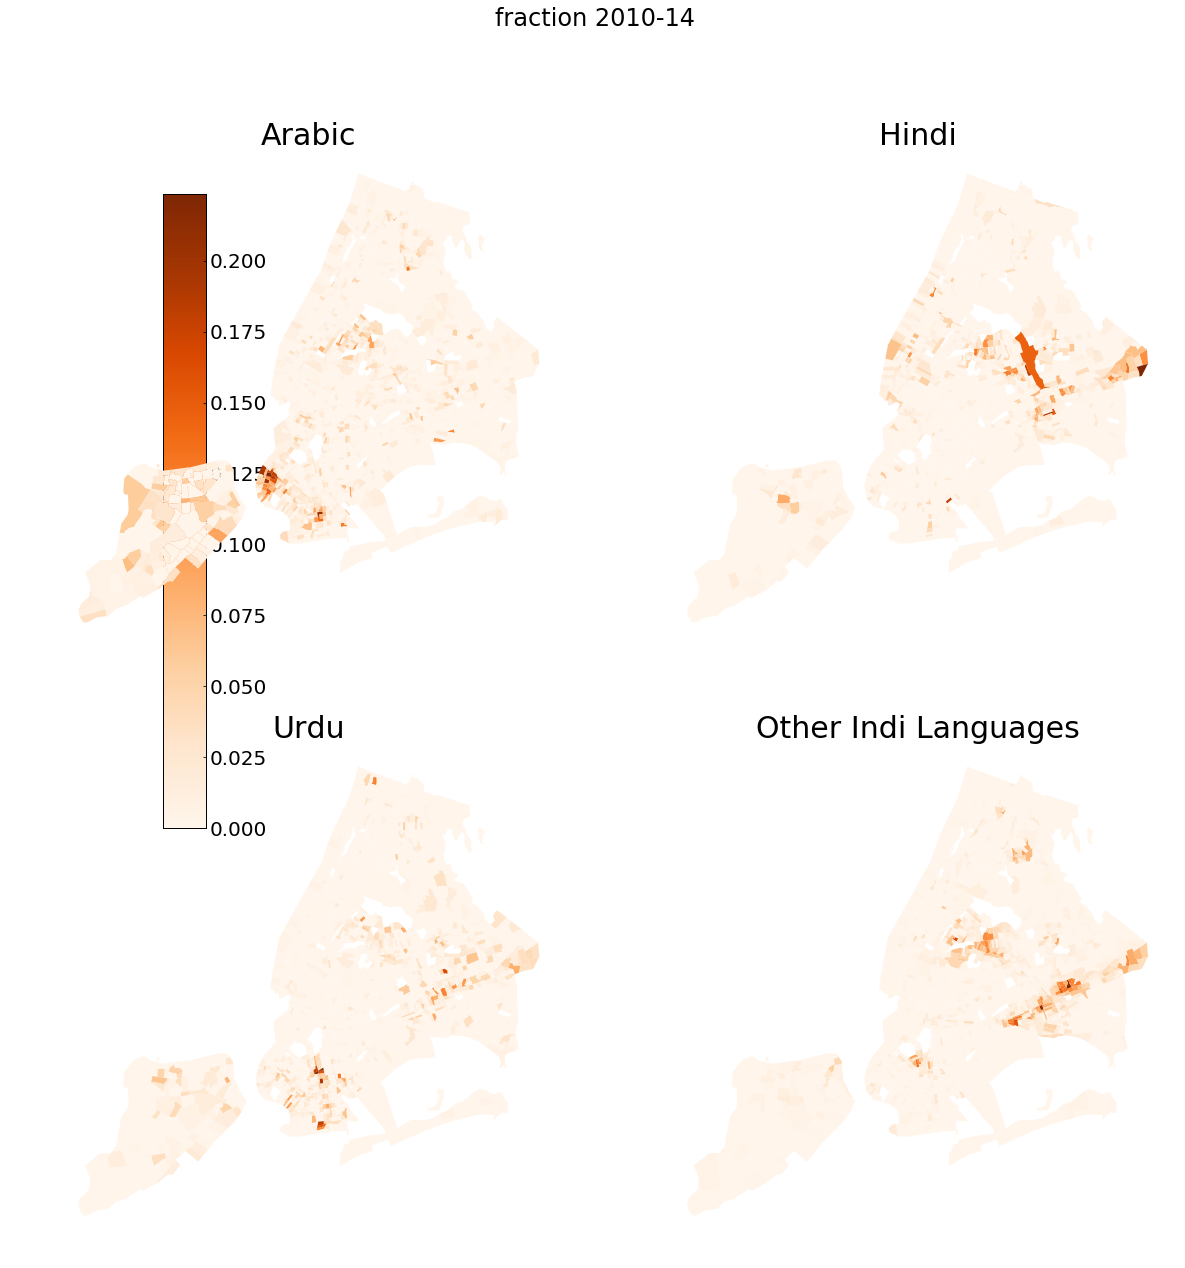

In [47]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(224)
f, ax = cp.choroplethNYC(geoLanguage, "fractionOther", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Other Indi Languages", fontsize=30)


ax = fig.add_subplot(221)

f, ax = cp.choroplethNYC(geoLanguage, "fractionArabic", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Arabic", fontsize=30)

ax = fig.add_subplot(222)

f, ax = cp.choroplethNYC(geoLanguage, "fractionHindi", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Hindi", fontsize=30)


ax = fig.add_subplot(223)

f, ax = cp.choroplethNYC(geoLanguage, "fractionUrdu", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Urdu", fontsize=30)
pl.suptitle('fraction 2010-14')
pl.savefig('fraction4Languages15.png')


## ACS 2010 data

In [48]:
# TODO aggregate at zipcode level
columns = ['GEO.id', 'HD01_VD108', 'HD01_VD54', 'HD01_VD57', 'HD01_VD60', 'HD01_VD01'] #pd.read
language2010 = pd.read_csv("data/ACS_10_5YR_B16001_with_ann.csv", usecols = columns)
language2010.rename(columns={'GEO.id':"id","HD01_VD108":"Arabic","HD01_VD54":"Hindi",
                             "HD01_VD57":"Urdu", 'HD01_VD01':'tot',
                             "HD01_VD60":"Other_Indic_languages"}, inplace=True)
language2010.drop(0, inplace=True)
language2010['allrelev'] = language2010[["Hindi", "Urdu", "Arabic"]].astype(float).sum(axis=1)
language2010.head()

id    tot Hindi Urdu Other_Indic_languages Arabic  \
1  1400000US36005000100  11517     0    0                    16      9   
2  1400000US36005000200   4014     0   23                   139      0   
3  1400000US36005000400   4640     0   66                     0     21   
4  1400000US36005001600   4793     0    0                     0      0   
5  1400000US36005001900   2013     0    0                     0      0   

   allrelev  
1       9.0  
2      23.0  
3      87.0  
4       0.0  
5       0.0

In [49]:
geoLanguage2010 = NYgeodata.merge(language2010, how="inner", right_on="id", left_on=u'AFFGEOID')#.plot(figsize = (20,20), column='allrelev')
geoLanguage2010.columns
geoLanguage2010['fraction'] = geoLanguage2010[['allrelev']].astype(float).values / geoLanguage2010[['tot']].astype(float).values
geoLanguage2010['fractionArabic'] = geoLanguage2010[['Arabic']].astype(float).values / geoLanguage2010[['tot']].astype(float).values
geoLanguage2010['fractionHindi'] = geoLanguage2010[['Hindi']].astype(float).values / geoLanguage2010[['tot']].astype(float).values
geoLanguage2010['fractionUrdu'] = geoLanguage2010[['Urdu']].astype(float).values / geoLanguage2010[['tot']].astype(float).values

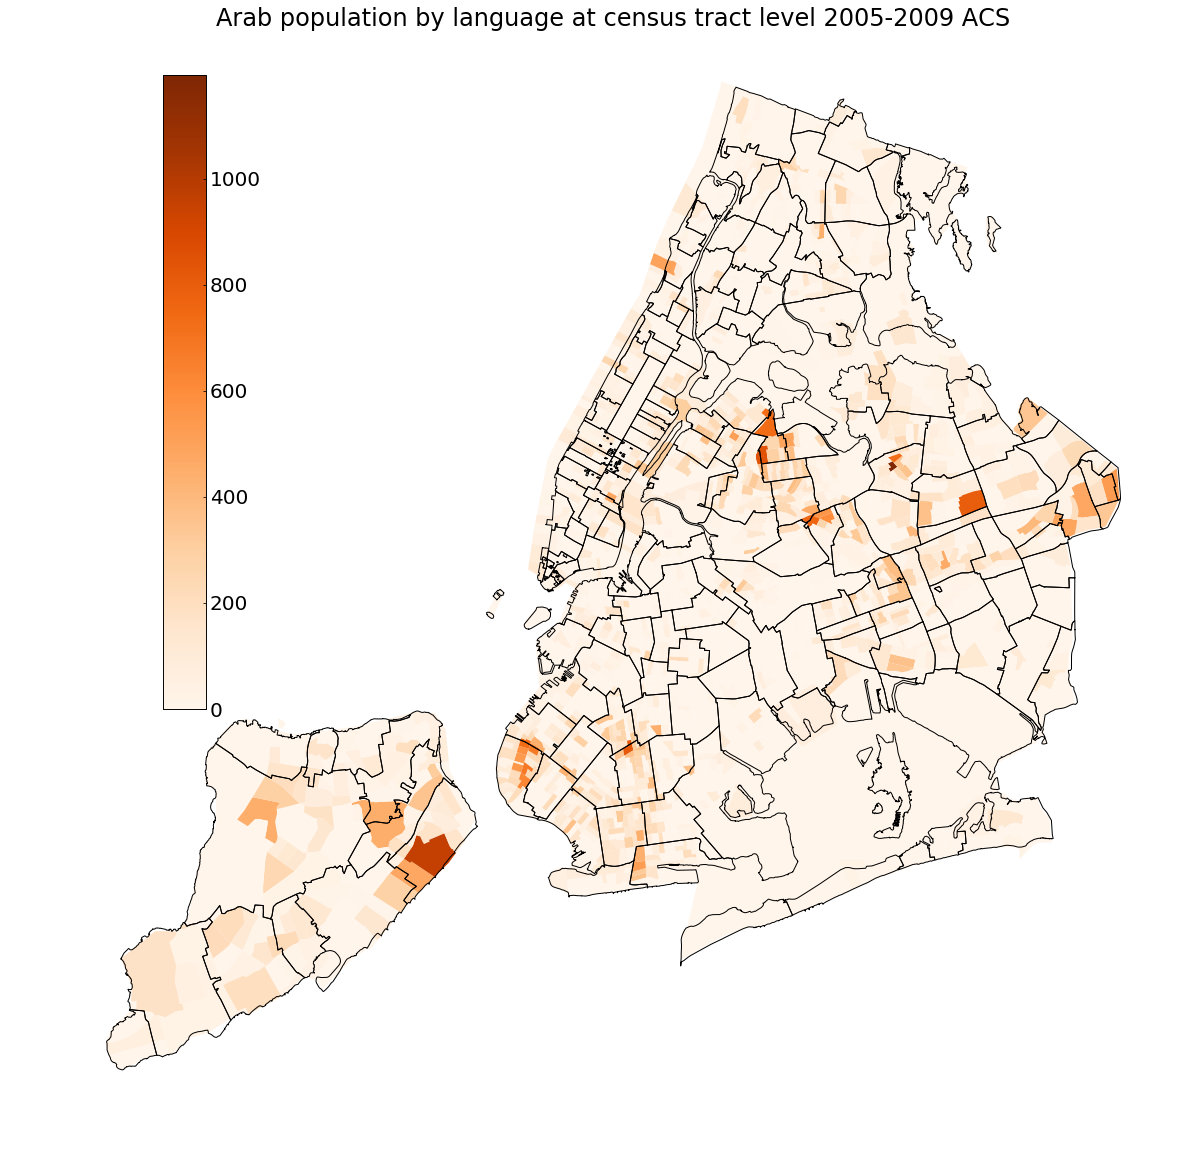

In [50]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)


f, ax = cp.choroplethNYC(geoLanguage2010, "allrelev", kind='continuous', cmap="Oranges", ax=ax, lw=0)
title = ax.set_title("Arab population by language at census tract level 2005-2009 ACS")
zips.plot(ax=ax, column=None, facecolor='none')
pl.savefig("ArabCountByLanguage10.png")

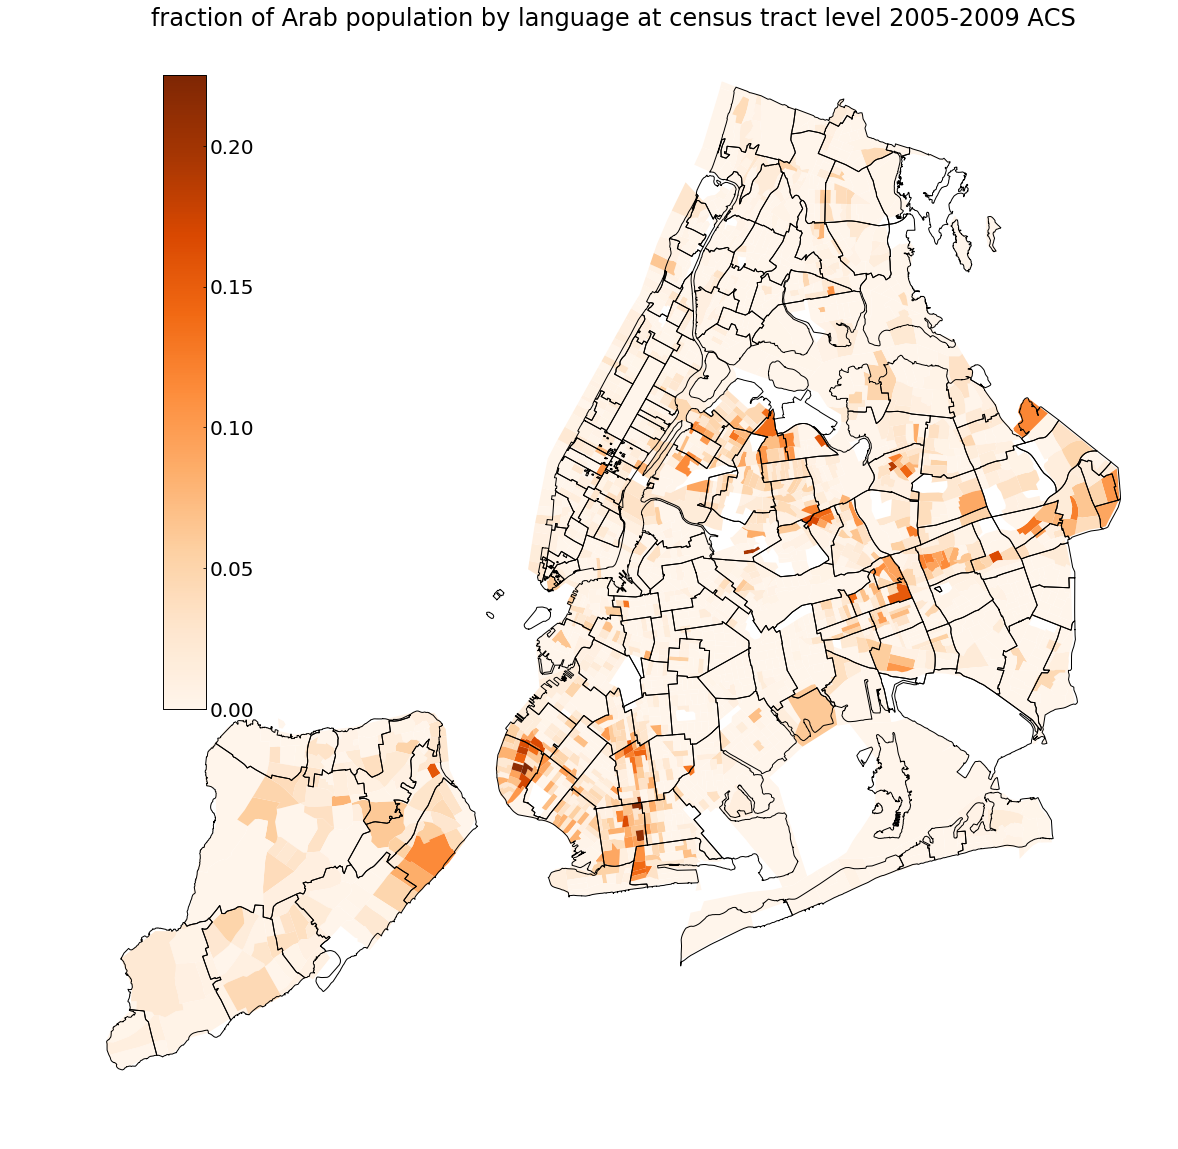

In [51]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)
f, ax = cp.choroplethNYC(geoLanguage2010, "fraction", kind='continuous', cmap="Oranges", ax=ax, lw=0)
title = ax.set_title("fraction of Arab population by language at census tract level 2005-2009 ACS")
zips.plot(ax=ax, column=None, facecolor='none')

pl.savefig("ArabByLanguage10.png")

In [52]:
geoLanguage2010['ctareaf2'] = geoLanguage2010[['geometry']].to_crs(epsg=2263)["geometry"].area / (2.788*10**7)
geoLanguage2010['density'] = geoLanguage2010[['allrelev']].astype(float).values.flatten() / geoLanguage2010['ctareaf2']
                    


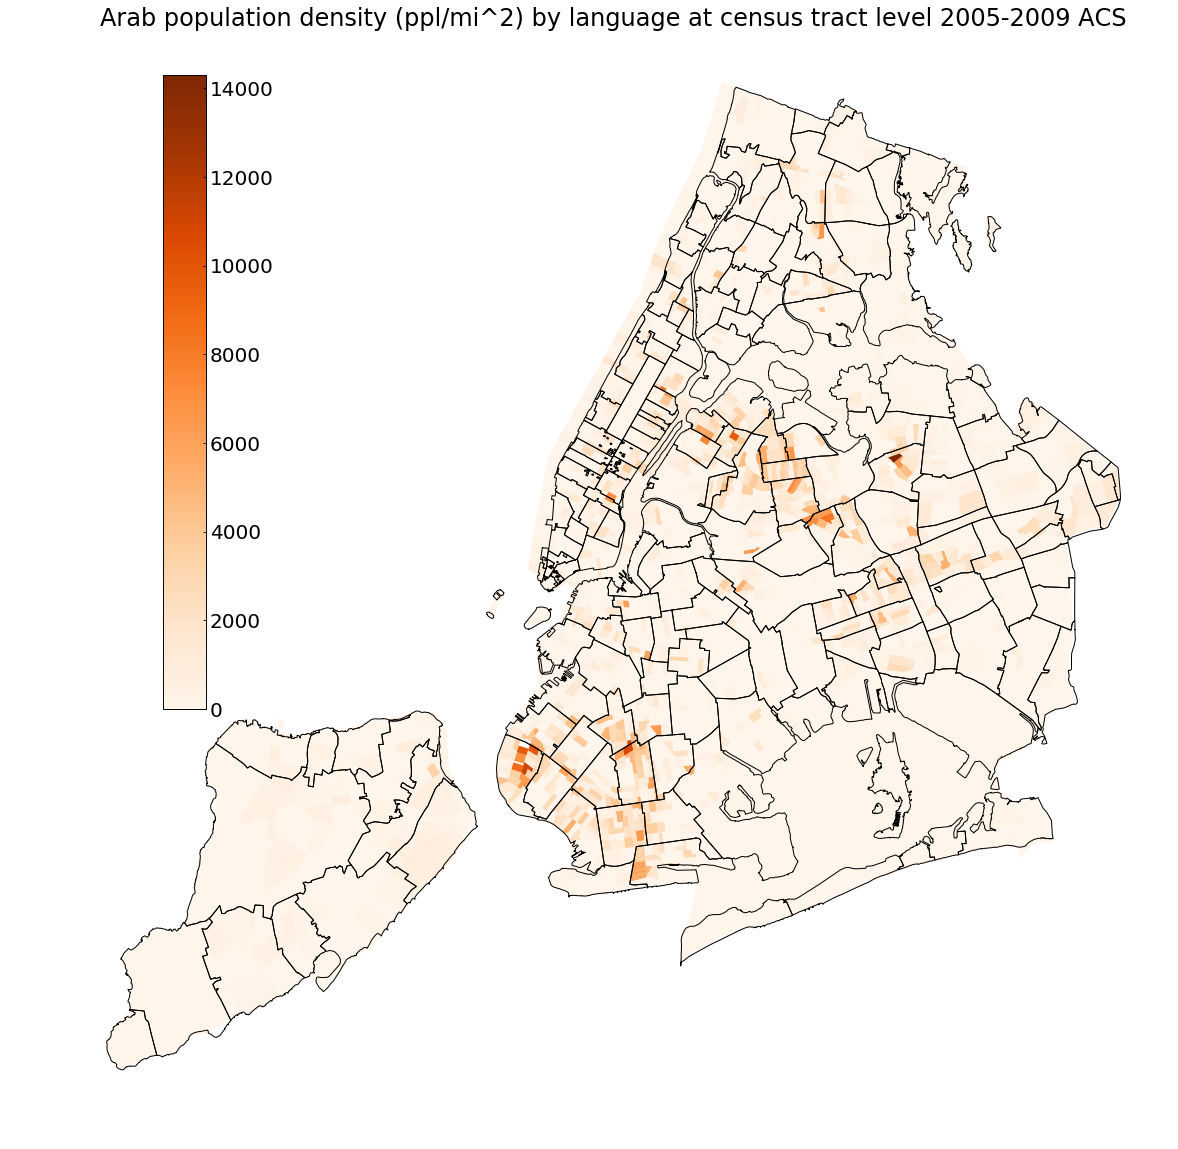

In [53]:
# note: in the density plot the 2 highest density zipcode for 2015 are removed as including it stretched the scale so that details are lost in the 2015 map
# for consistency we remove them here too
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)

f, ax = cp.choroplethNYC(geoLanguage2010[geoLanguage['density'].values<15000], "density", 
                         kind='continuous', cmap="Oranges", ax=ax, lw=0)
title = ax.set_title("Arab population density (ppl/mi^2) by language at census tract level 2005-2009 ACS")
zips.plot(ax=ax, column=None, facecolor='none')
pl.savefig("ArabDensity10.png")

Index([u'max', u'geometry', u'min', u'center'], dtype='object')

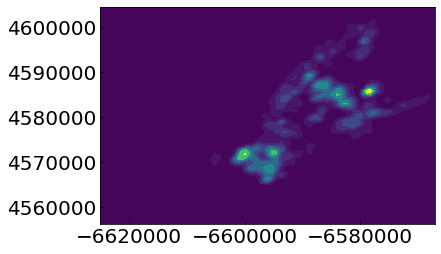

In [54]:
StePot10 = smoomapy.SmoothStewart(geoLanguage2010.to_crs(epsg=2263), "density", span=500,
                           beta=2, mask=geoLanguage2010.to_crs(epsg=2263))
res10 = StePot10.render(nb_class=8, func_grid="matplotlib",
                        disc_func="jenks", output="GeoDataFrame")
res10.columns

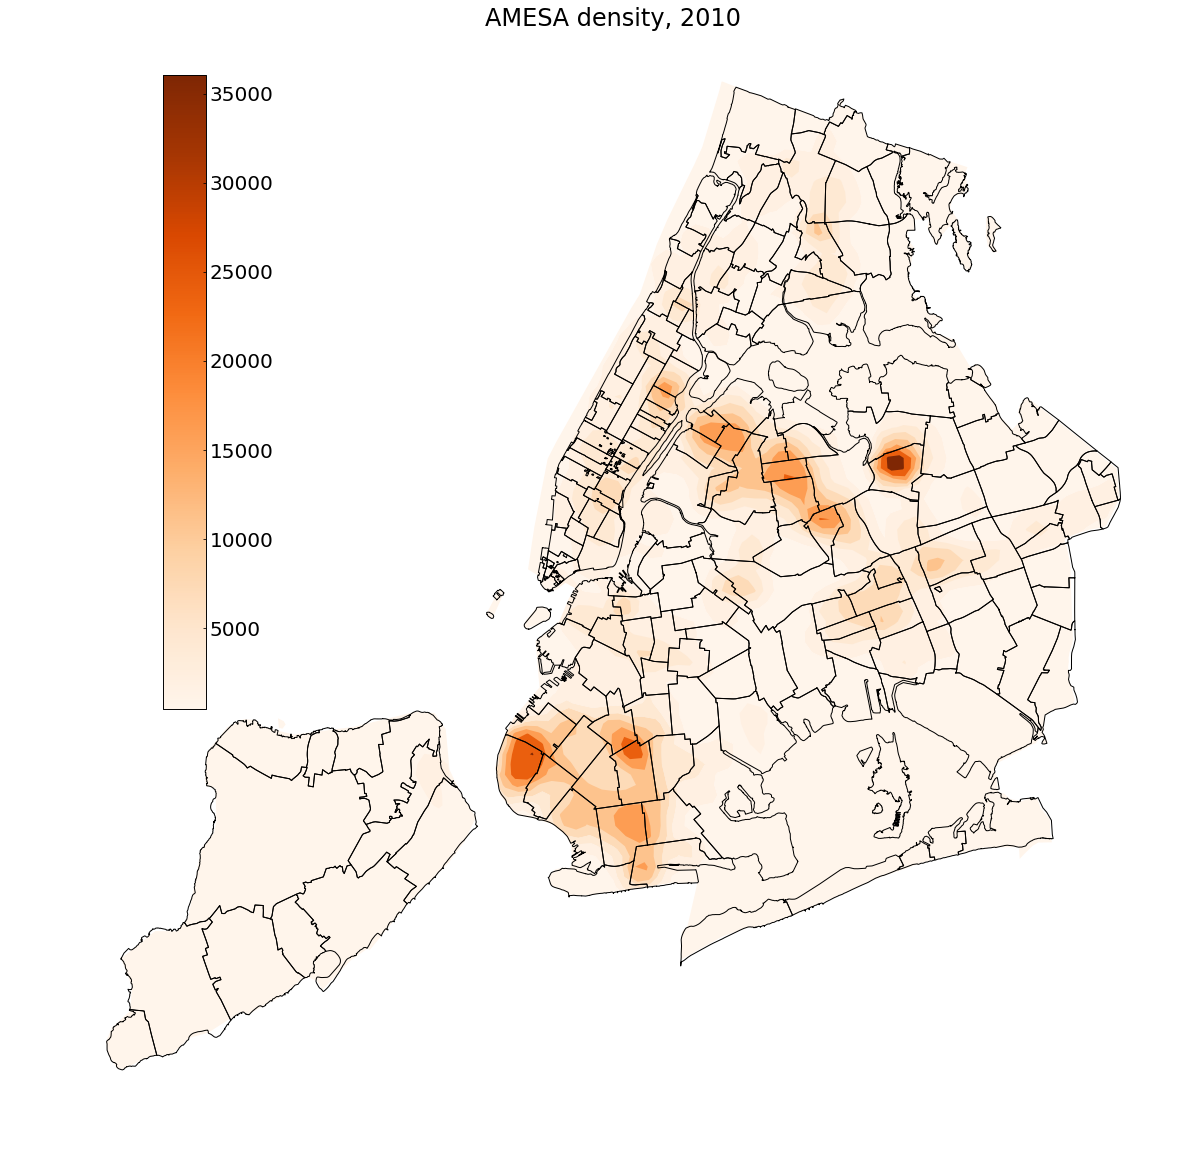

In [55]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)
f, ax = cp.choroplethNYC(res10.to_crs(epsg=4326), "center", kind='continuous', cmap="Oranges", ax=ax, lw=0)

zips.plot(ax=ax, column=None, facecolor='none')
title = ax.set_title("AMESA density, 2010")

pl.savefig("ArabDensity2010Smooth.png")

In [56]:
geoLanguage2010['fractionOther'] = geoLanguage2010[['Other_Indic_languages']].astype(float).values / geoLanguage2010[['tot']].astype(float).values

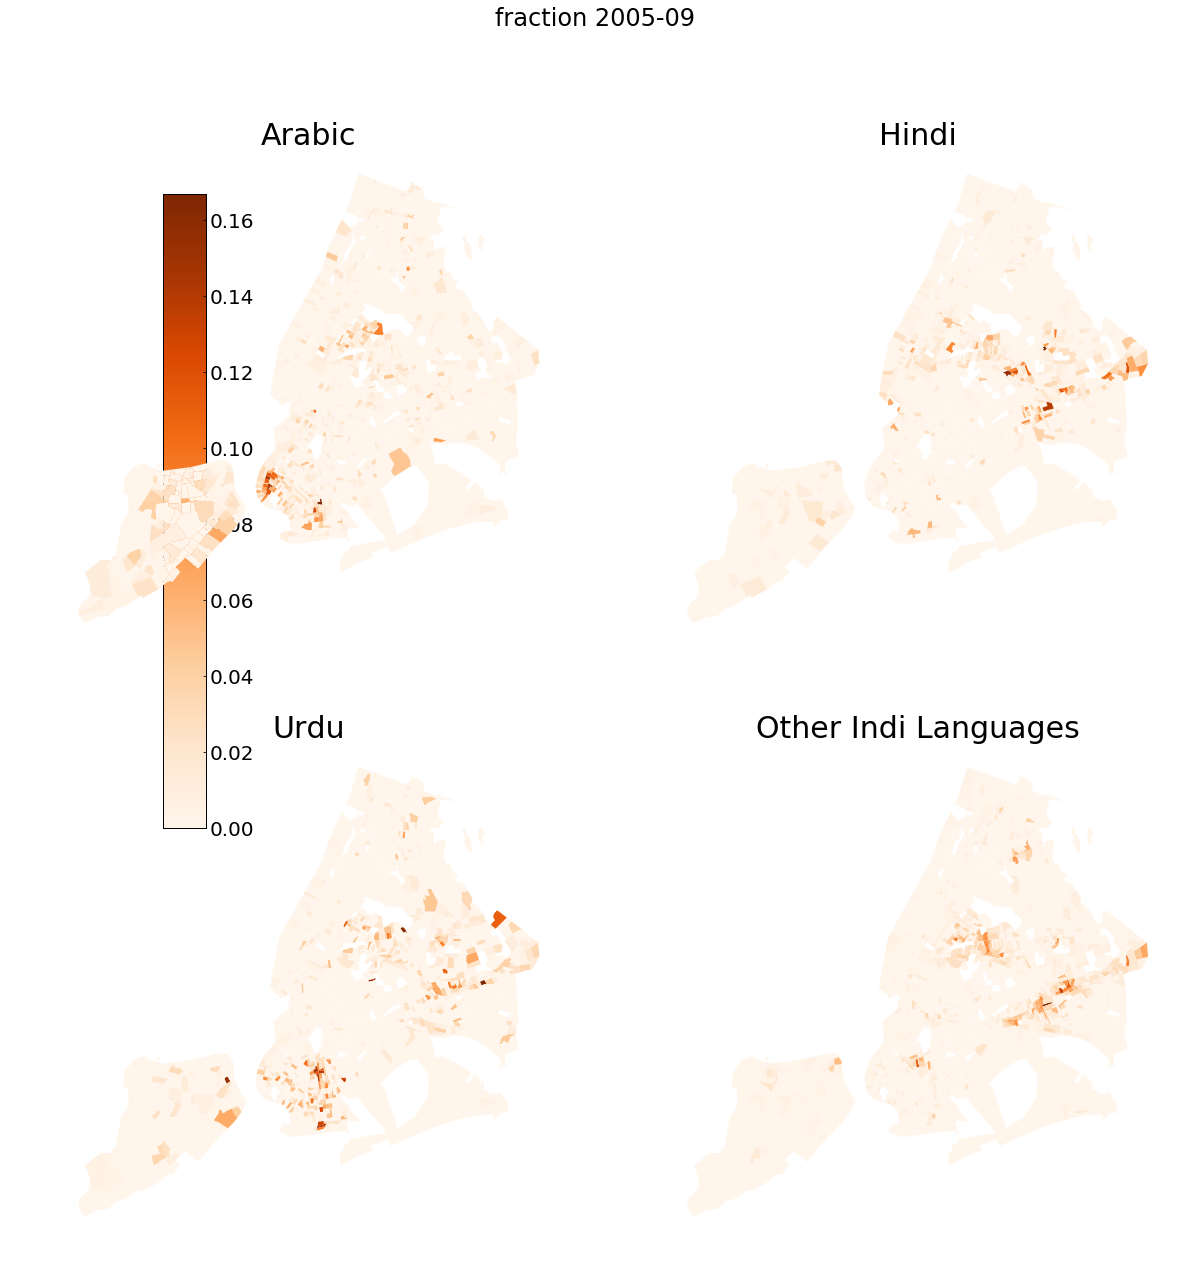

In [57]:
fig = pl.figure(figsize=(20,20))

ax = fig.add_subplot(224)

f, ax = cp.choroplethNYC(geoLanguage2010, "fractionOther", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Other Indi Languages", fontsize=30)

ax = fig.add_subplot(221)

f, ax = cp.choroplethNYC(geoLanguage2010, "fractionArabic", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Arabic", fontsize=30)

ax = fig.add_subplot(222)

f, ax = cp.choroplethNYC(geoLanguage2010, "fractionHindi", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Hindi", fontsize=30)

ax = fig.add_subplot(223)

f, ax = cp.choroplethNYC(geoLanguage2010, "fractionUrdu", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Urdu", fontsize=30)
pl.suptitle('fraction 2005-09')

pl.savefig('fraction4Languages10.png')


# time evolution 

In [58]:
geomerged_20102015 = geoLanguage2010.merge(geoLanguage[["id","fraction"]], on="id")
geomerged_20102015["growth"] = geomerged_20102015.fraction_y.astype(float).values - geomerged_20102015.fraction_x.astype(float).values 

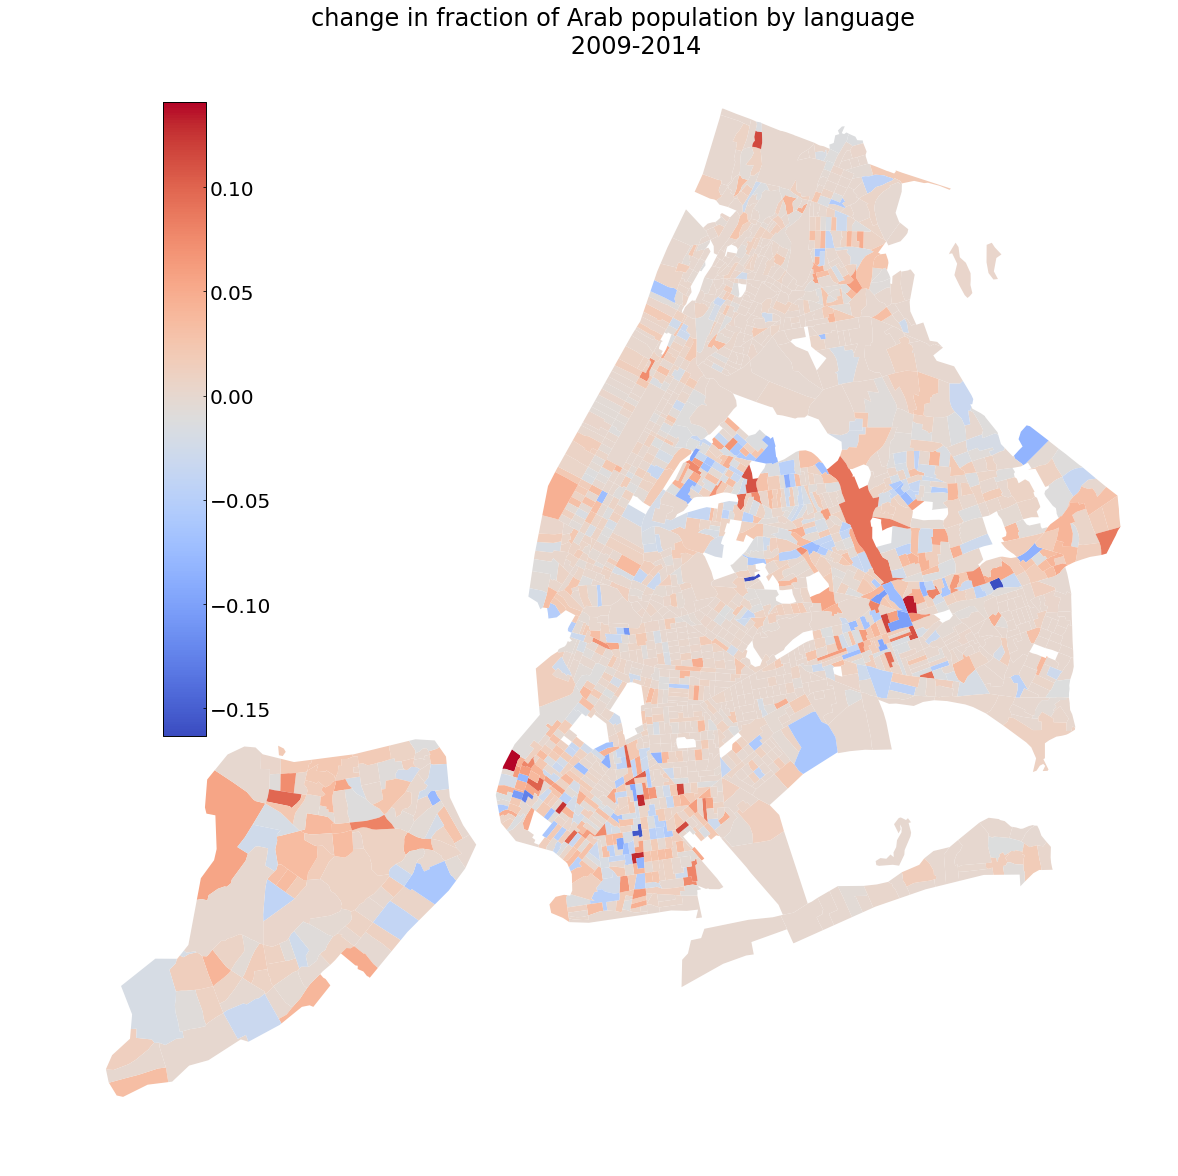

In [59]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)
f, ax = cp.choroplethNYC(geomerged_20102015, "growth", kind='continuous', cmap="coolwarm", ax=ax, lw=0)
title = ax.set_title("change in fraction of Arab population by language\n      2009-2014")
pl.savefig("ArabSpeakersChanges.png")

In [60]:
locations = {
    'l1':{"name":"AAFSC Brooklyn","address":"150 Court Street, 3rd Floor Brooklyn, NY 11201", 'lat':0., 'lng':0.},
    "l2":{"name":"AAFSC Queens", "address":"37-10 30th St, 2nd Fl Long Island City, NY 11101", 'lat':0., 'lng':0.},
    "l3":{"name":"AAFSC Family Justice Center Brooklyn", "address":"350 Jay Street Brooklyn, NY 11201", 'lat':0., 'lng':0.},
    "l4":{"name":"AAFSC Family Justice Center Queens","address":"126-02 82nd Avenue Queens, NY 11415", 'lat':0., 'lng':0.},
    "l5":{"name":"AAFSC Family Justice Center Staten Island","address":"126 Stuyvesant Place Staten Island, NY 10301", 'lat':0., 'lng':0.}
}

for l,loc in locations.iteritems():
    url = "https://maps.googleapis.com/maps/api/geocode/json?address=%s&key=%s"%(loc['address'].replace(" ","+"),os.getenv('GOOGLEAPI'))
    latlon = get_jsonparsed_data(url)["results"][0]['geometry']['location']

    loc['lat'] =  latlon['lat']
    loc['lng'] =  latlon['lng']
    loc['lonlat'] = (loc['lng'],loc['lat'])
    
locationsdf = pd.DataFrame.from_dict(locations, orient='index',)
locationsdf['geometry']=locationsdf[['lonlat']].applymap(lambda x: shapely.geometry.Point(list(x)) )
locationsdf = gpd.GeoDataFrame(locationsdf)

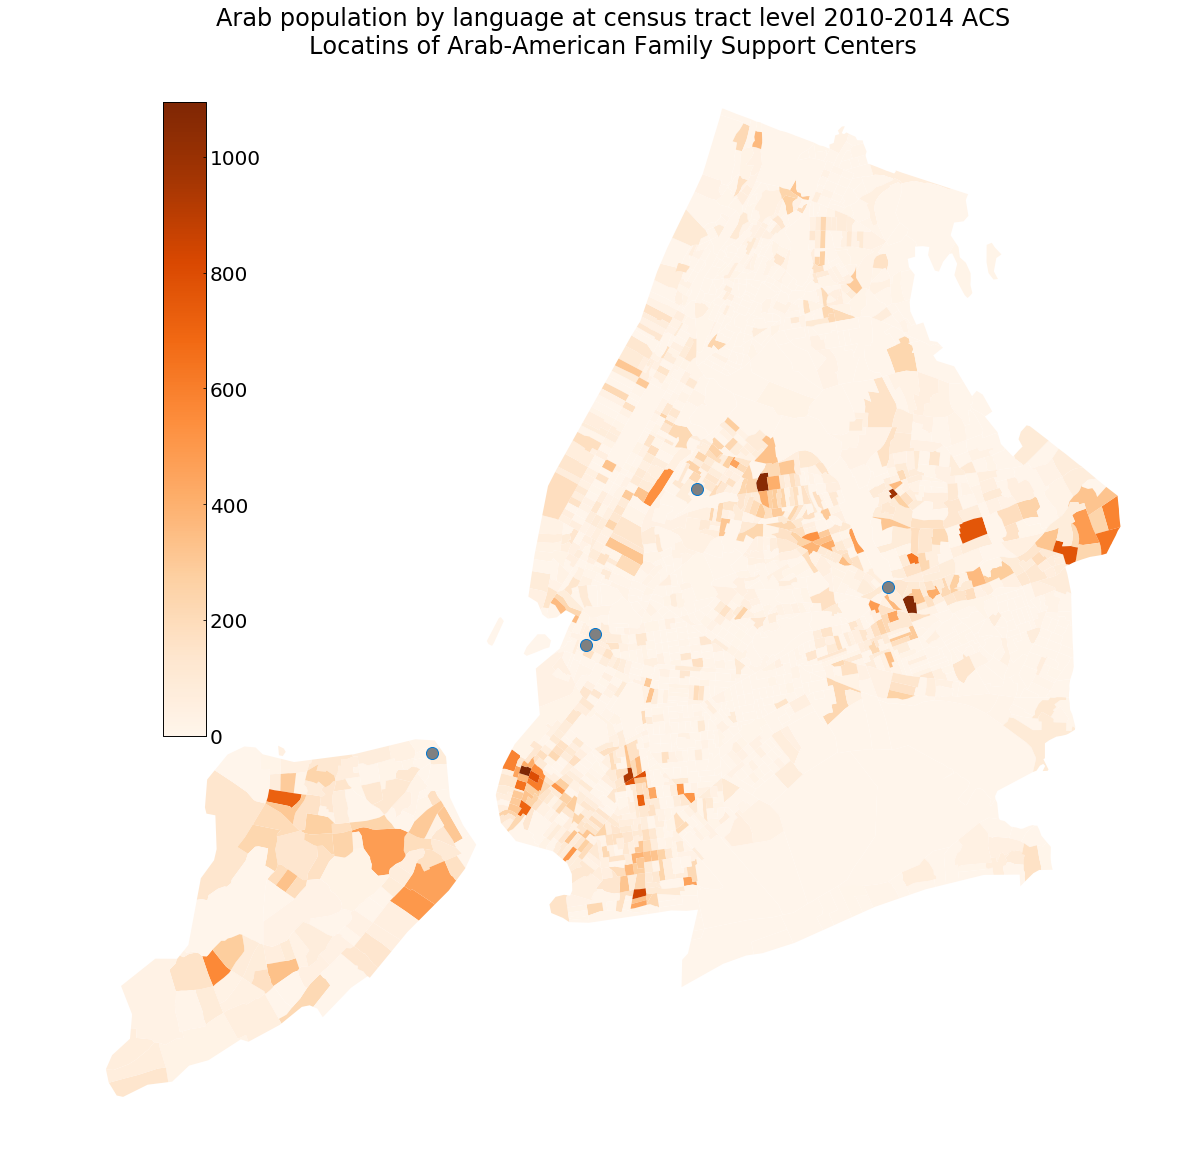

In [63]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)
f, ax = cp.choroplethNYC(geoLanguage, "allrelev", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
locationsdf.plot(ax=ax, marker='o', color="#0077d1", markersize=12)
locationsdf.plot(ax=ax, marker='o', color='Gray', markersize=10)
title = ax.set_title("Arab population by language at census tract level 2010-2014 ACS\nLocatins of Arab-American Family Support Centers")
pl.savefig("AAFSClocations.png")